In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import signal
from ephysvibe.trials import select_trials,align_trials
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.task import task_constants
import glm_functions
import os
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
# import structures
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.eye_data import EyeData
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
# Torch
import torch
import torch.nn as nn
import torch.distributions as D
import torch.functional as F
from torch.utils.data import TensorDataset,DataLoader
from sklearn.metrics import mean_poisson_deviance
import nn_model 
from sklearn.model_selection import KFold

In [2]:
seed=2024

### Read data

In [3]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'C:/Users/camil/Documents/int/'

In [129]:
# Load data
neu_path = basepath+"/session_struct/lip/neurons/2023-11-30_11-16-24_Riesling_lip_e1_r1_good1_neu.h5"#  2023-12-06_11-17-19_Riesling_lip_e1_r1_good4
neu_data = NeuronData.from_python_hdf5(neu_path)
#2022-12-02_11-01-23_Riesling_lip_e1_r1_good4
#2023-11-30_11-16-24_Riesling_lip_e1_r1_good1 
#2023-11-30_11-16-24_Riesling_lip_e1_r1_good3
#2023-11-30_11-16-24_Riesling_lip_e1_r1_mua4

### Preproces data
* select trials 
* define stimulus
* define basis
* convole stimulus with its corresponding base -> desing matrix
* stack spikes and desing matrices

In [130]:
# parameters
time_before=0
select_block=1

In [131]:
# Select trials aligned to start_trial
code=1
sp_sample_on,mask = align_trials.align_on(
    sp_samples=neu_data.sp_samples,
    code_samples=neu_data.code_samples,
    code_numbers=neu_data.code_numbers,
    trial_error=neu_data.trial_error,
    block=neu_data.block,
    pos_code=neu_data.pos_code,
    select_block= select_block,
    select_pos= code,
    event ="sample_on",
    time_before = time_before,
    error_type= 0,
)

In [132]:
# Number of basis for each stimulus
fix_cue_dim=4
fixation_dim=5
sample_dim=40
delay_dim=40
test_dim=20
match_dim=10
bar_dim=10
hist_cos_dim = 15
hist_box_dim = 10
hist_dim = hist_cos_dim+hist_box_dim
# Compute basis
cos_basis=glm_functions.make_non_linear_raised_cos(nBases=hist_cos_dim, binSize=1, endPoints=np.array([10,150]), nlOffset=1)
single_bin_boxcars = np.zeros((cos_basis.shape[0],hist_box_dim))
single_bin_boxcars[range(hist_box_dim),range(hist_box_dim)]=1
hist_b = np.concatenate((single_bin_boxcars,cos_basis),axis=1)
fix_cue_b = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=fix_cue_dim,duration=500)
fixation_b = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=fixation_dim,duration=1200)
sample_b = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=sample_dim,duration=400)
delay_b = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=delay_dim,duration=400)
test_b = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=test_dim,duration=400)
match_b = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=match_dim,duration=200)
bar_release_b = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=bar_dim,duration=80)
# create dict with the basis
basis={'fix_cue':fix_cue_b,'fixation':fixation_b,'hist':hist_b,
       's_on_off':[np.nan],
       's_11':sample_b,'s_15':sample_b,
       's_51':sample_b,'s_55':sample_b,'s_n0':sample_b,
       'd_11':delay_b,'d_15':delay_b,'d_51':delay_b,'d_55':delay_b,'d_n0':delay_b,'d_on_off':[np.nan]}
for i in range(1,9):
    basis['test_color'+str(i)] = test_b
    basis['test_orient'+str(i)] = test_b
for i in range(1,5):
    basis['test_on_off'+str(i)] = [np.nan]
basis['match'] = match_b
basis['bar_release'] = bar_release_b

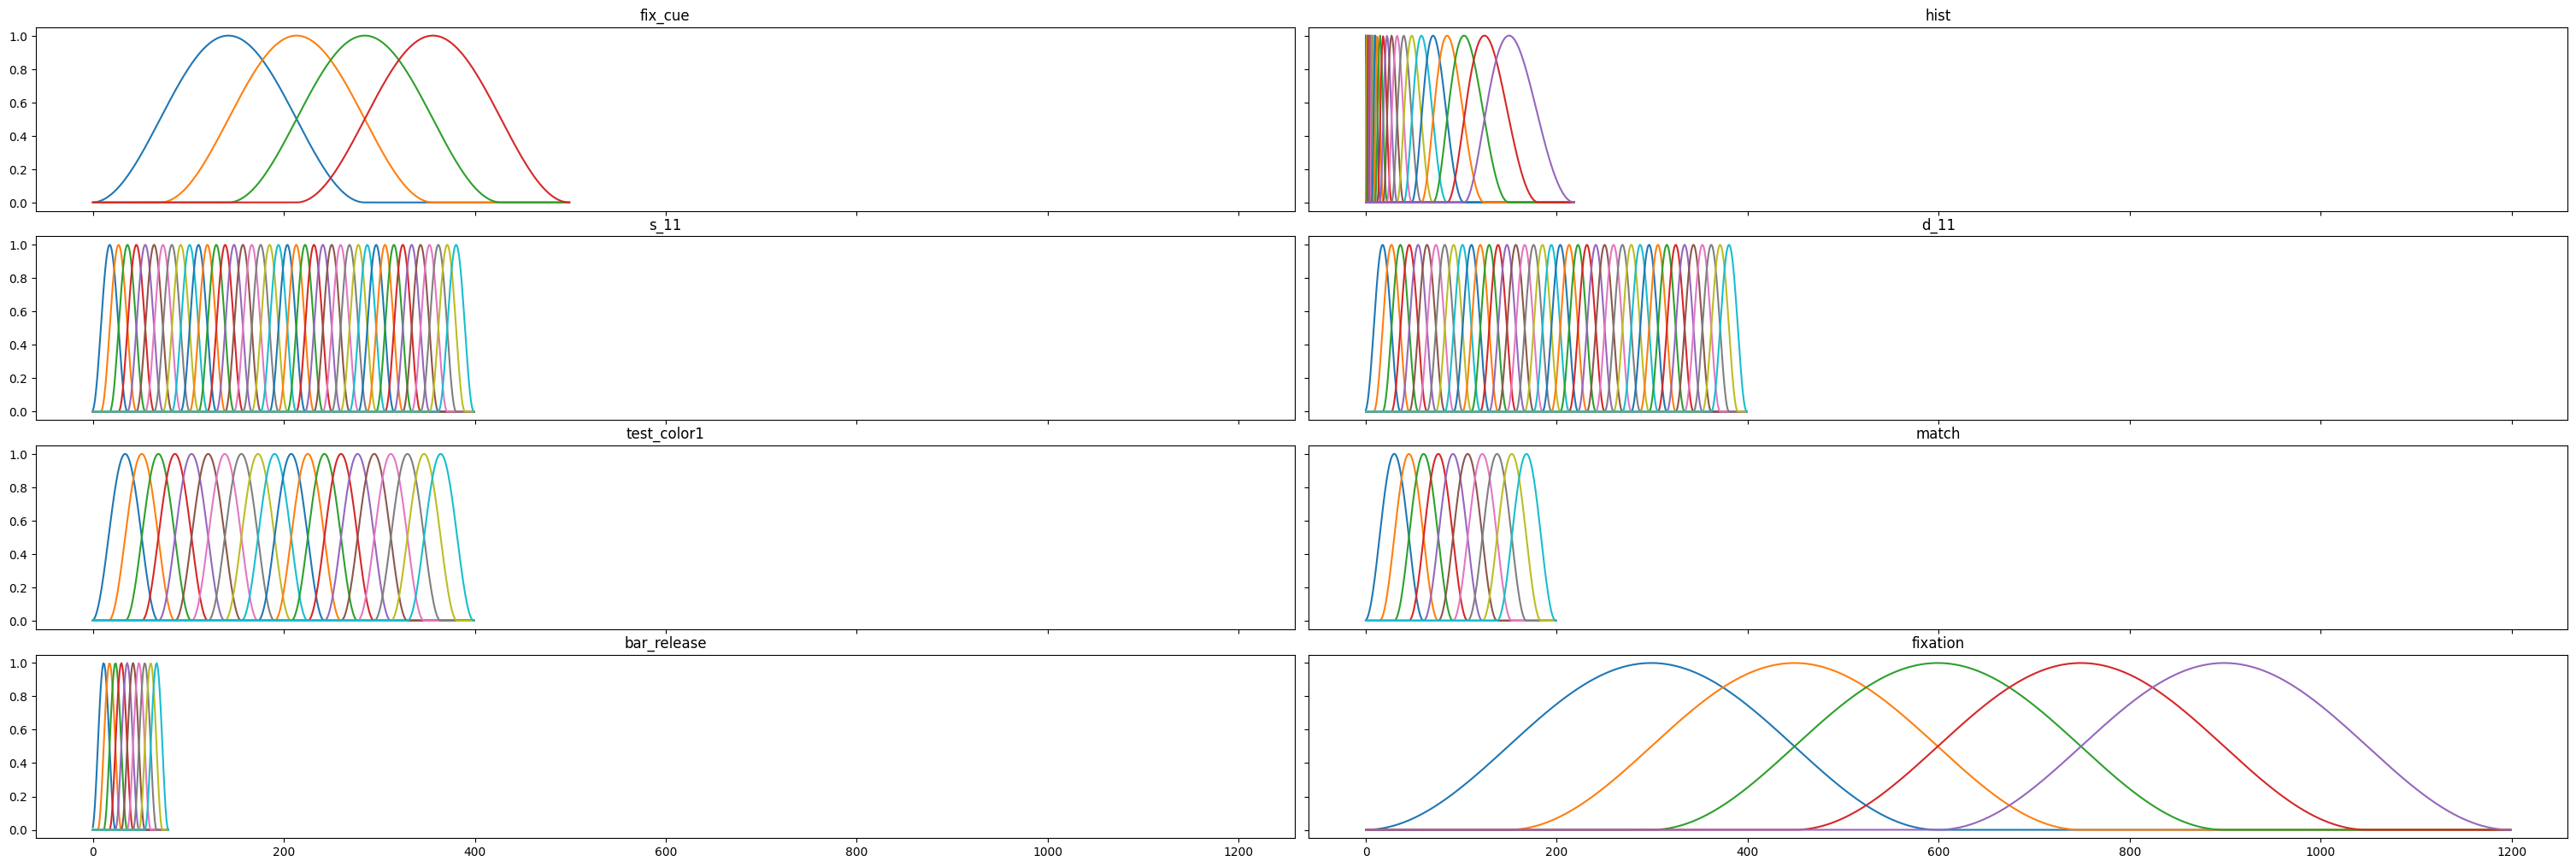

In [133]:
# print filters
plot_b = True
if plot_b:
    basis_keys = ['fix_cue', 'hist', 's_11', 'd_11', 'test_color1', 'match', 'bar_release','fixation']
    cols = 2
    rows = len(basis_keys)//cols
    rows =rows +1 if len(basis_keys)%cols>0 else rows
    f,ax=plt.subplots(rows,cols,figsize=(30,10),sharey=True,sharex=True)
    for iax,var in zip(np.concatenate(ax),basis_keys):
        iax.plot(basis[var])
        iax.set_title(var)
    f.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.8)

In [134]:
events = [# "fix_cue", # "fixation", 
    "hist","s_11", "s_15", "s_51", "s_55", "s_n0",
    #"s_on_off",
    "d_11", "d_15","d_51", "d_55", "d_n0",
    #"d_on_off",
    # "test_orient1", "test_orient2", "test_orient3", "test_orient4",  "test_orient5", "test_orient6",# "test_orient7", "test_orient8",
    # "test_color1",  "test_color2",  "test_color3", "test_color4", "test_color5",  "test_color6",  "test_color7", "test_color8",
    # #"match", "bar_release",
]
last_event = "test_on_1"#"reward"#

In [135]:
# select trials index
sample_id=neu_data.sample_id[mask]
# select trials per sample
sn0_tr= np.where(sample_id== 0)[0]
s15_tr= np.where(sample_id== 15)[0]
s11_tr= np.where(sample_id== 11)[0]
s55_tr= np.where(sample_id== 55)[0]
s51_tr= np.where(sample_id== 51)[0]
# Shuffle trials
rng = np.random.default_rng(seed=seed)
rng.shuffle(sn0_tr)
rng.shuffle(s15_tr)
rng.shuffle(s11_tr)
rng.shuffle(s55_tr)
rng.shuffle(s51_tr)
print(len(sn0_tr))
print(len(s15_tr))
print(len(s11_tr))
print(len(s55_tr))
print(len(s51_tr))

52
58
65
51
48


In [136]:
n_is = 10
st_tt= n_is*5
# Select trials for testing
sn0= sn0_tr[:n_is]
s15= s15_tr[:n_is]
s11= s11_tr[:n_is]
s55= s55_tr[:n_is]
s51= s51_tr[:n_is]
idxs_trials =np.concatenate((sn0,s15,s11,s55,s51))
if len(idxs_trials)!=n_is*5:
    print(False)
print(len(sn0))
print(len(s15))
print(len(s11))
print(len(s55))
print(len(s51))
# rng = np.random.default_rng(seed=seed)
# rng.shuffle(idxs_train)
# Select trials for training
# sn0= sn0_tr[n_tn:n_tn+n_tt]
# s15= s15_tr[n_tn:n_tn+n_tt]
# s11= s11_tr[n_tn:n_tn+n_tt]
# s55= s55_tr[n_tn:n_tn+n_tt]
# s51= s51_tr[n_tn:n_tn+n_tt]
# idxs_test =np.concatenate((sn0,s15,s11,s55,s51))
# rng = np.random.default_rng(seed=seed)
# rng.shuffle(idxs_test)
# idxs_test
# idxs = np.concatenate((idxs_train,idxs_test))

10
10
10
10
10


In [137]:
idxs_trials.shape

(50,)

In [138]:
design_mat = []
all_dm =[]
all_len_tr = []
all_s_on = []
all_fix_on=[]
all_stim=[]
all_sp = []
all_d_on=[]
all_test1_on=[]
all_sample_id=[]
n_tr,_ = sp_sample_on.shape
data    =   Parallel(n_jobs = -1)(delayed(glm_functions.get_dm)(i_tr, last_event, events, neu_data, time_before, sp_sample_on, mask, basis) for i_tr in tqdm(idxs_trials))
for asc in data:
    design_mat.append(asc["design_mat"])
    all_dm.append(asc["all_dm"])
    all_len_tr.append(asc["len_tr"])
    all_s_on.append(asc["s_on"])
    all_fix_on.append(asc["fix_on"])
    all_d_on.append(asc["delay_on"])
    all_stim.append(asc["stim"])
    all_sp.append(asc["sp"])
    all_test1_on.append(asc["test1_on"])
    all_sample_id.append(int(asc["sample_id"]))
indices= data[0]["indices"]

100%|██████████| 50/50 [02:51<00:00,  3.43s/it]


In [139]:
i_trs=6
neu_data.sample_id[mask][idxs_trials]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 11., 11., 11., 11., 11., 11.,
       11., 11., 11., 11., 55., 55., 55., 55., 55., 55., 55., 55., 55.,
       55., 51., 51., 51., 51., 51., 51., 51., 51., 51., 51.])

In [140]:
np.array(all_sample_id)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 55, 55, 55, 55,
       55, 55, 55, 55, 55, 55, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51])

In [141]:
plot_stim=False
if plot_stim:
    f,ax=plt.subplots(figsize=(20,5))
    #ax.plot(all_stim[0]['fixation'],label='fixation')
    # ax.plot(all_stim[i_trs]['hist'],label='hist')
    # ax.plot(all_sp[i_trs],'k',label='truehist')
    #ax.plot(all_stim[i_trs]['fix_cue'],label='fix_cue')
    ax.plot(all_stim[i_trs]['s_55'],label='s_55')
    ax.plot(all_stim[i_trs]['s_15'],label='s_15',linestyle='--')
    ax.plot(all_stim[i_trs]['s_11'],label='s_11')
    ax.plot(all_stim[i_trs]['s_51'],label='s_51',linestyle='--')
    ax.plot(all_stim[i_trs]['s_n0'],label='s_n0')
    # ax.plot(all_stim[i_trs]['d_55'],label='d_55')
    # ax.plot(all_stim[i_trs]['d_15'],label='d_15',linestyle='--')
    plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')

In [142]:
sn0_pos= np.where(np.array(all_sample_id)== 0)[0]
s15_pos= np.where(np.array(all_sample_id)== 15)[0]
s11_pos= np.where(np.array(all_sample_id)== 11)[0]
s55_pos= np.where(np.array(all_sample_id)== 55)[0]
s51_pos= np.where(np.array(all_sample_id)== 51)[0]
# # Shuffle trials
# rng = np.random.default_rng(seed=seed)
print(len(sn0_pos))
print(len(s15_pos))
print(len(s11_pos))
print(len(s55_pos))
print(len(s51_pos))
idx_dict={'sn0':sn0_pos, 's15':s15_pos,'s11':s11_pos,'s55':s55_pos,'s51':s51_pos}

10
10
10
10
10


In [143]:
def get_idx_trials_train_val(idx_train,idx_val,idx_dict,seed):
    # Select trials for training and validation
    sn0= idx_dict['sn0'][idx_train]
    s15= idx_dict['s15'][idx_train]
    s11= idx_dict['s11'][idx_train]
    s55= idx_dict['s55'][idx_train]
    s51= idx_dict['s51'][idx_train]
    idxs_train =np.concatenate((sn0,s15,s11,s55,s51))
    rng = np.random.default_rng(seed=seed)
    rng.shuffle(idxs_train)
    # validation
    sn0= idx_dict['sn0'][idx_val]
    s15= idx_dict['s15'][idx_val]
    s11= idx_dict['s11'][idx_val]
    s55= idx_dict['s55'][idx_val]
    s51= idx_dict['s51'][idx_val]
    idxs_val =np.concatenate((sn0,s15,s11,s55,s51))
    rng.shuffle(idxs_val)
    return idxs_train, idxs_val

In [144]:
idx_dict['s55'].shape

(10,)

In [145]:
kf=KFold(n_splits=5, shuffle=False)
kfolds = list(kf.split(np.arange(n_is)))
ki_train,ki_val = kfolds[1]
idxs_train, idxs_val = get_idx_trials_train_val(ki_train,ki_val,idx_dict,seed)

In [146]:
# train
n_train=len(idxs_train)
sp_train=np.concatenate(list(all_sp[i] for i in idxs_train.tolist()))
print("Length of all trials concatenated: %s"%sp_train.shape)
dm_train_1=np.concatenate(list(design_mat[i] for i in idxs_train.tolist())) 
print("Shape of dm: (%s, %s)"%dm_train_1.shape)
len_tr_train=np.array(all_len_tr)[idxs_train]
print("Number of trials %s"%len_tr_train.shape)
s_on_train=np.array(all_s_on)[idxs_train]
fix_on_train=np.array(all_fix_on)[idxs_train]
d_on_train=np.array(all_d_on)[idxs_train]
test1_on_train=np.array(all_test1_on)[idxs_train]
# validation
sp_test=np.concatenate(list(all_sp[i] for i in idxs_val.tolist()))
print("Length of all trials concatenated: %s"%sp_test.shape)
dm_test_1=np.concatenate(list(design_mat[i] for i in idxs_val.tolist())) 
print("Shape of dm: (%s, %s)"%dm_test_1.shape)
len_tr_test=np.array(all_len_tr)[idxs_val]
print("Number of trials %s"%len_tr_test.shape)
s_on_test=np.array(all_s_on)[idxs_val]
fix_on_test=np.array(all_fix_on)[idxs_val]
d_on_test=np.array(all_d_on)[idxs_val]
test1_on_test=np.array(all_test1_on)[idxs_val]

Length of all trials concatenated: 52426
Shape of dm: (52426, 425)
Number of trials 40
Length of all trials concatenated: 13189
Shape of dm: (13189, 425)
Number of trials 10


In [147]:
#dm_train_all=np.concatenate(list(design_mat[i] for i in range(len(design_mat)))) 

# x=dm_train_all
# mu = np.mean(x,axis=0)
# sigma = np.std(x,axis=0)
# sigma0 = sigma
# sigma0[sigma0==0] = 1

x=dm_train_1
mu = np.mean(x,axis=0)
sigma = np.std(x,axis=0)
sigma0 = sigma
sigma0[sigma0==0] = 1
dm_train = (x-mu) / sigma0

x_test=dm_test_1
mu = np.mean(x_test,axis=0)
sigma = np.std(x_test,axis=0)
sigma0 = sigma
sigma0[sigma0==0] = 1
dm_test = (x_test-mu) / sigma0


In [148]:
# T,nreg=dm_train.shape
# design_mat_offset = np.hstack((np.ones((T,1)), dm_train))  
# T_test,nreg=dm_test.shape
# design_mat_offset_test = np.hstack((np.ones((T_test,1)), dm_test))  

### Try with NN

In [149]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [150]:
def train_model(model,X_ten_train,y_ten_train,X_ten_test,y_ten_test,epochs,optimizer,criterion,early_stopping,regl1=None,regl2=None):
    losses_train,losses_test,acc_test,acc_train,allit_w = [],[],[],[],[]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    reg_loss1,reg_loss2=0,0
    regularizer1,regularizer2 =None,None
    if regl1 != None and regl2 != None:
        regularizer1 = regl1
        regularizer2 = regl2
    elif regl1 != None:
        regularizer1 = regl1
    elif regl2 != None:
        regularizer2 = regl2

    for _ in range(epochs):
        model.train()
        batch_loss=0
        batch_acc=0
        #for X_loader, y_loader in train_loader:
        #X_loader,y_loader=X_loader.to(device),y_loader.to(device)
        optimizer.zero_grad() # zero out gradients
        y_pred_train = model(X_ten_train) # fordward propagation
        loss_train = criterion(y_pred_train, y_ten_train) # computing the loss
        if regularizer1 != None:
            reg_loss1 = regularizer1(model)
        if regularizer2 != None:
            reg_loss2 = regularizer2(model)
        loss_train = loss_train  + reg_loss1 +reg_loss2
        loss_train.backward() # backpropagation
        #batch_loss+= loss_train.item() 
        acc = mean_poisson_deviance(y_ten_train.cpu().detach().numpy().reshape(-1),y_pred_train[:,0].cpu().detach().numpy())
        #batch_acc+=acc
        optimizer.step() # optimize (GD)
        losses_train.append(loss_train.cpu().detach().numpy().item())
        acc_train.append(acc)
        model.eval()
        y_pred_test = model(X_ten_test)
        loss_test = criterion(y_pred_test, y_ten_test)      
        losses_test.append(loss_test.cpu().detach().numpy().item())
        acc_test.append(mean_poisson_deviance(y_ten_test.cpu().detach().numpy(),y_pred_test[:,0].cpu().detach().numpy()))
        # Check early stopping criteria
        early_stopping(loss_train, model)
        if early_stopping.early_stop:
            # print("Early stopping")
            break
    return losses_train,losses_test,acc_train,acc_test, model
    

In [151]:
# Split data
X_train =  dm_train#design_mat_offset#np.random.rand(1000, 1).astype(np.float32)  # 
y_train = sp_train[:,np.newaxis]#np.exp(2 * X) + np.random.normal(0, 0.1, size=(1000, 1)).astype(np.float32)  #  rng.poisson(1,size=sp_train.shape[0])[:,np.newaxis] #
X_test = dm_test
y_test = sp_test[:,np.newaxis]#.copy() # rng.integers(low=0, high=2, size=sp_test.shape[0], dtype=int)[:,np.newaxis]#sp_test  sp_test.shape[0]
# Convert data to PyTorch tensors
X_ten_train = torch.from_numpy(X_train).to(torch.float32).to(device)
y_ten_train = torch.from_numpy(y_train).to(torch.int).to(device)
X_ten_test = torch.from_numpy(X_test).to(torch.float32).to(device)
y_ten_test = torch.from_numpy(y_test).to(torch.int).to(device)
# Avg y to compute acc
# y_ten_avg = torch.from_numpy(firing_rate.moving_average(data=y_train[:,0], win=20, step = 1)).to(torch.float32) 
# y_test_ten_avg = torch.from_numpy(firing_rate.moving_average(data=y_test[:,0], win=20, step = 1)).to(torch.float32)

In [152]:
# train_dataset = TensorDataset(X_ten_train, y_ten_train)
# # Use DataLoader for training and testing
# # For reproducibility
# g_seed = torch.Generator()
# g_seed.manual_seed(seed)
# batch_size = 100000
# shuffle_train = False
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=shuffle_train)

In [153]:
np.arange(0,1,1/100000)[np.arange(0,11000,100)][:30]

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029])

In [154]:
# TODO Create a DataLoader 
# dataset = TensorDataset(X_tensor, y_tensor)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
lambdasl1= np.arange(0,1,1/20000)[:30]#np.concatenate(([0],2**np.arange(20))) 
lambdasl2= np.arange(0,1,1/10000)
lambdas = np.arange(0,1,1/100000)[np.arange(0,11000,100)][:30]#np.concatenate(([0],(2**np.arange(30))/100000000))
all_losses_train,all_losses_test,all_acc_test,all_acc_train = {},{},{},{}
all_models = {}
lambdas=[0,0.000005,0.00001,0.00005,0.0001,0.0006,0.0009,0.001,0.005,0.01,0.03,0.05,0.09]
for il,lam in enumerate(lambdas):
    torch.manual_seed(seed)
    glm_model = nn_model.ExpModel(input_dim, output_dim).to(device)
    # Define the loss function and optimizer
    criterion = nn_model.poisson_glm_loss# nn.PoissonNLLLoss(False)#
    optimizer = torch.optim.Adam(glm_model.parameters(), lr=0.01)#, weight_decay=lam)
    # Train the model
    epochs = 10000
    early_stopping = nn_model.EarlyStopping(patience=1000, verbose=True,delta=0.00001)
    regl1 = None#nn_model.L1Regularization(beta=0.00005)#lambdasl1[2])#
    regl2 = nn_model.SmoothL2Regularization(beta=lam)
    # regularizer = SmoothL2Regularization(beta=lam)
    losses_train,losses_test, acc_train,acc_test,trained_model= train_model(glm_model,X_ten_train,y_ten_train,X_ten_test,y_ten_test,epochs,optimizer,criterion,early_stopping,regl1=regl1,regl2=regl2)
    all_models[str(lam)]=trained_model.cpu() # save trained models in a dict

    all_losses_train[str(lam)]=losses_train
    all_losses_test[str(lam)]=losses_test
    all_acc_train[str(lam)]=acc_train
    all_acc_test[str(lam)]=acc_test
    # all_acc_test.append(acc_test)
    # all_acc.append(acc)
    # all_allit_w.append(allit_w)


Validation loss decreased (inf --> 0.131890).  Saving model ...
Validation loss decreased (0.131890 --> 0.131880).  Saving model ...
Validation loss decreased (0.131880 --> 0.131870).  Saving model ...
Validation loss decreased (0.131870 --> 0.131860).  Saving model ...
Validation loss decreased (0.131860 --> 0.131851).  Saving model ...
Validation loss decreased (0.131851 --> 0.131841).  Saving model ...
Validation loss decreased (0.131841 --> 0.131831).  Saving model ...
Validation loss decreased (0.131831 --> 0.131821).  Saving model ...
Validation loss decreased (0.131821 --> 0.131811).  Saving model ...
Validation loss decreased (0.131811 --> 0.131802).  Saving model ...
Validation loss decreased (0.131802 --> 0.131792).  Saving model ...
Validation loss decreased (0.131792 --> 0.131782).  Saving model ...
Validation loss decreased (0.131782 --> 0.131773).  Saving model ...
Validation loss decreased (0.131773 --> 0.131763).  Saving model ...
Validation loss decreased (0.131763 -->

Text(0.5, 0, '[0, 5e-06, 1e-05, 5e-05, 0.0001, 0.0006, 0.0009, 0.001, 0.005, 0.01, 0.03, 0.05, 0.09]')

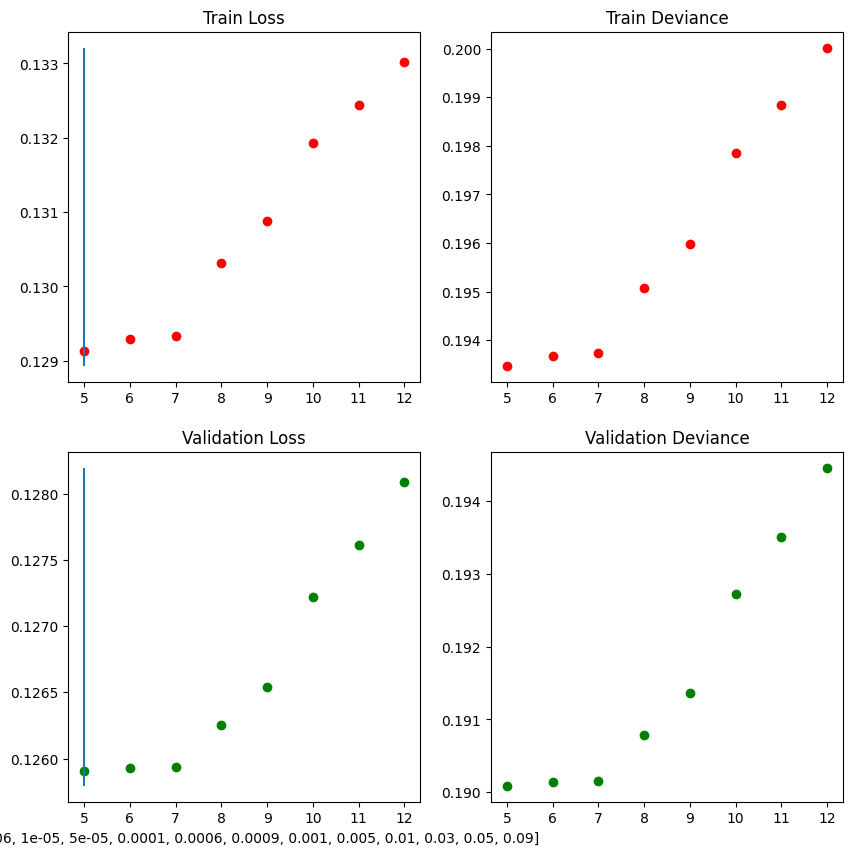

In [179]:
lam_min=1
i_min=0
f,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(10,10))
for i in range(5,len(lambdas)):
    y=np.array(all_losses_train[str(lambdas[i])])[-1]
    ax1.scatter(i,y,c='r')
    y=np.array(all_acc_train[str(lambdas[i])])[-1]
    ax2.scatter(i,y,c='r')
    y=np.array(all_losses_test[str(lambdas[i])])[-1]
    if i!=0:
        if y<lam_min: 
            lam_min = y 
            i_min = i 
         
    ax3.scatter(i,y,c='g')
    y=np.array(all_acc_test[str(lambdas[i])])[-1]
    ax4.scatter(i,y,c='g')
ax1.set_title("Train Loss")  
ax2.set_title("Train Deviance")  
ax3.set_title("Validation Loss")  
ax4.set_title("Validation Deviance")  
ax1.vlines(i_min,ax1.get_ylim()[0],ax1.get_ylim()[1])
ax3.vlines(i_min,ax3.get_ylim()[0],ax3.get_ylim()[1])
ax3.set_xlabel(lambdas)

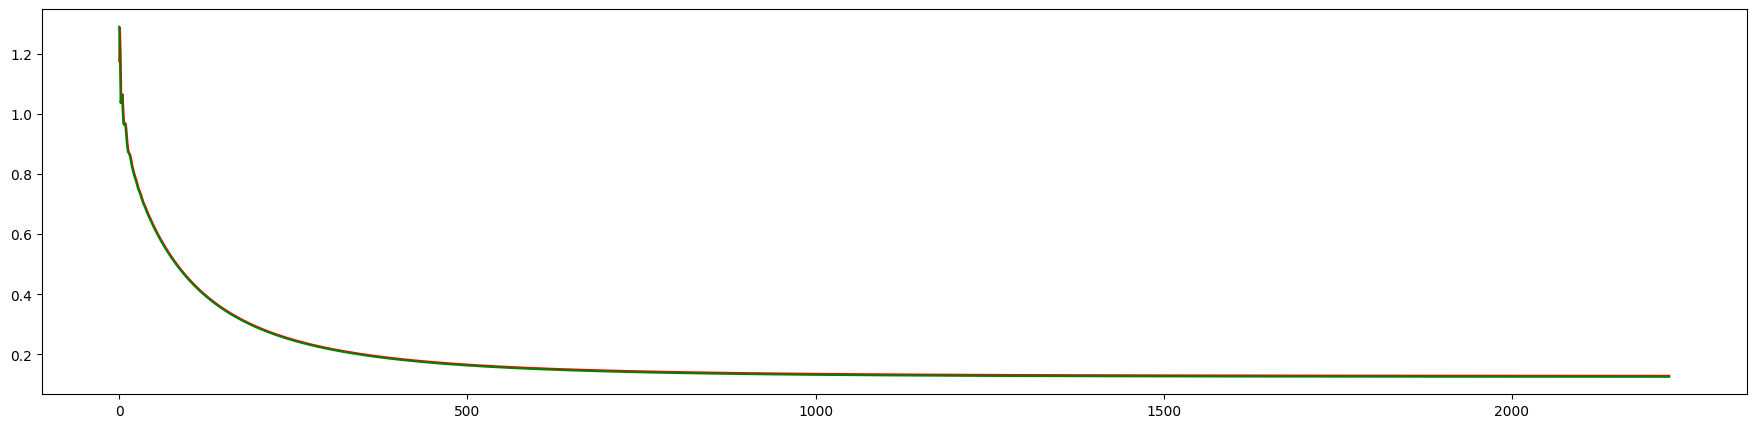

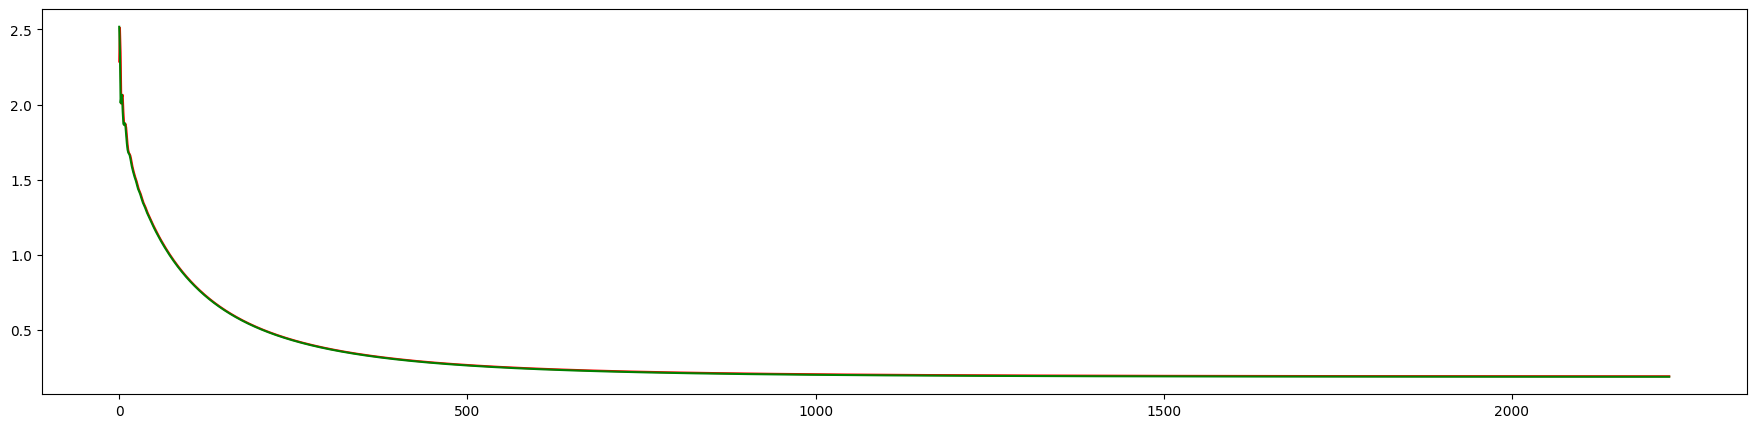

In [180]:
color=['r','b','r','b','r','b','r','b','r','b','r','b','g']
plt.subplots(figsize=(22,5))
for i in [i_min]:#range(0,2):
    plt.plot(np.array(all_losses_train[str(lambdas[i])]),'r')
    plt.plot(np.array(all_losses_test[str(lambdas[i])]),'g')
plt.subplots(figsize=(22,5))
for i in [i_min]:
    plt.plot(np.array(all_acc_train[str(lambdas[i])]),'r')
    plt.plot(np.array(all_acc_test[str(lambdas[i])]),'g')

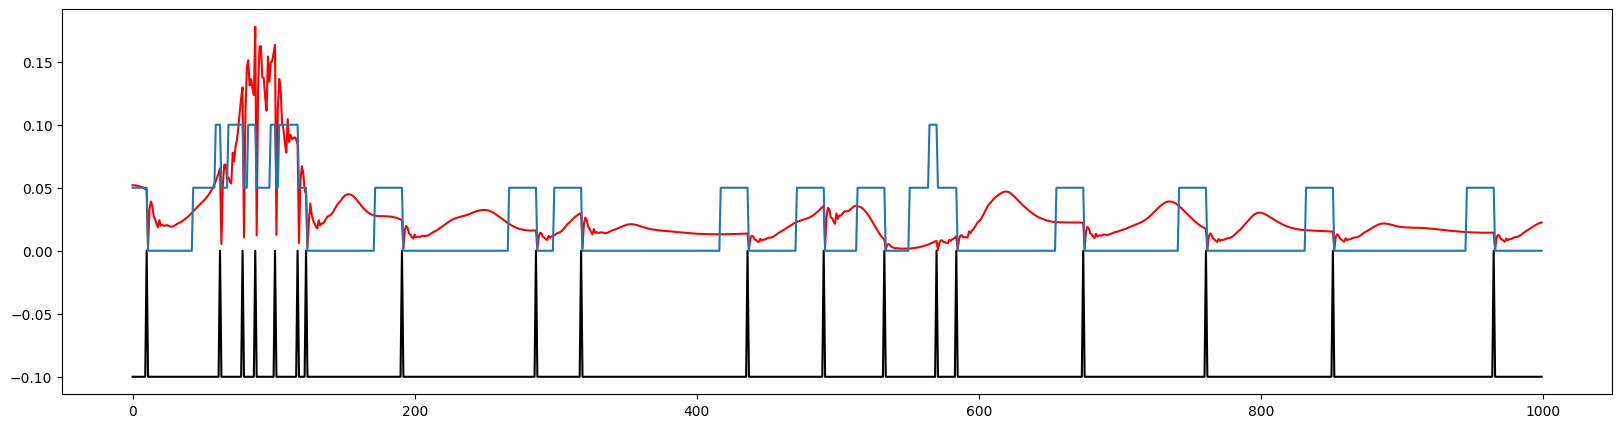

In [181]:
#plt.subplots(figsize=(20,5))
color=['r','b','r','b','g']
X_ten_train=X_ten_train.cpu()
for i,lam in enumerate(lambdas[i_min:i_min+1]):
    plt.subplots(figsize=(20,5))
    lam_model = all_models[str(lam)]
    lam_model.eval()
    predictions = lam_model(X_ten_train)
    predictions = predictions.detach().numpy()
    plt.plot(predictions[:1000],color[i])
plt.plot(y_train[:1000]/10-0.1,'k')
plt.plot(firing_rate.moving_average(data=sp_train[:1000], win=20, step = 1))

In [182]:
list(glm_model.parameters())[1]

Parameter containing:
tensor([-3.6353], requires_grad=True)

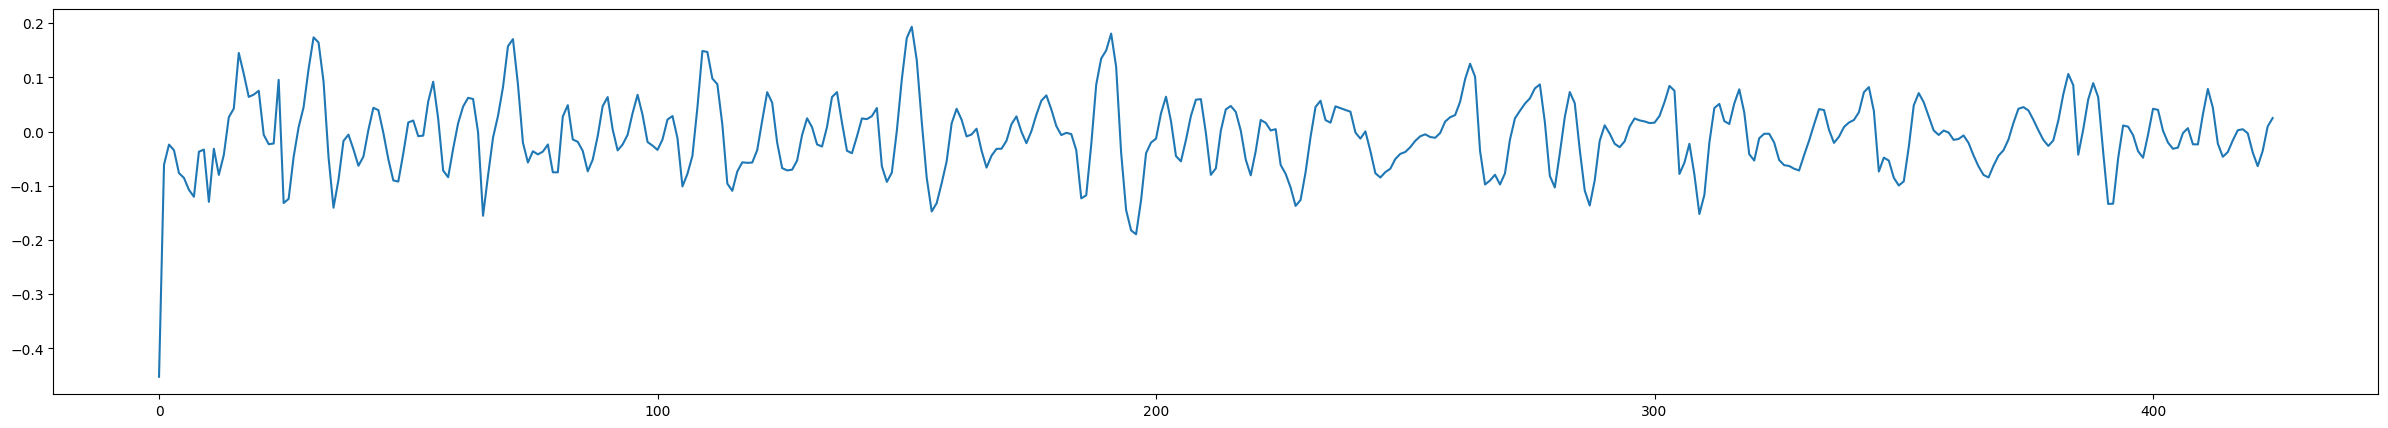

In [183]:
lam_model = all_models[str(lambdas[i_min])]
plt.subplots(figsize=(30,5))
plt.plot(list(lam_model.parameters())[0][0,:].detach().numpy())

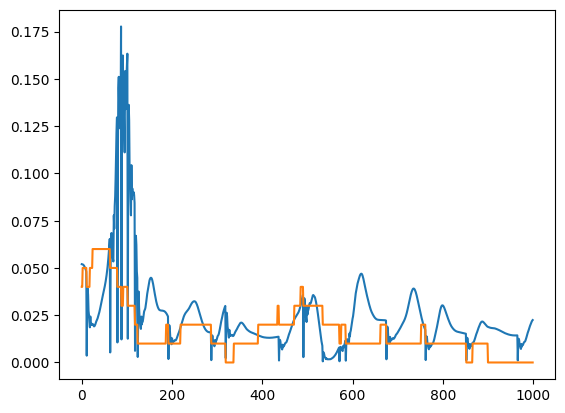

In [184]:
plt.plot(predictions[:1000])
plt.plot(firing_rate.moving_average(data=sp_train[:1000], win=100, step = 1))#firing_rate.moving_average(data=sp_train[:1000], win=20, step = 1))

In [185]:
list(glm_model.parameters())[1][0].detach().numpy()

array(-3.635349, dtype=float32)

In [186]:
rate_pred_train = predictions#np.exp(glm_const + dm_train@ wparams[1:])#glm_result.params

hist
-0.7445021
s_11
-0.14835232
s_15
-0.0879803
s_51
-0.13737676
s_55
-0.11360648
s_n0
-0.34842277
d_11
-0.40121147
d_15
-0.3078933
d_51
-0.40862802
d_55
-0.38260305
d_n0
-0.36763436


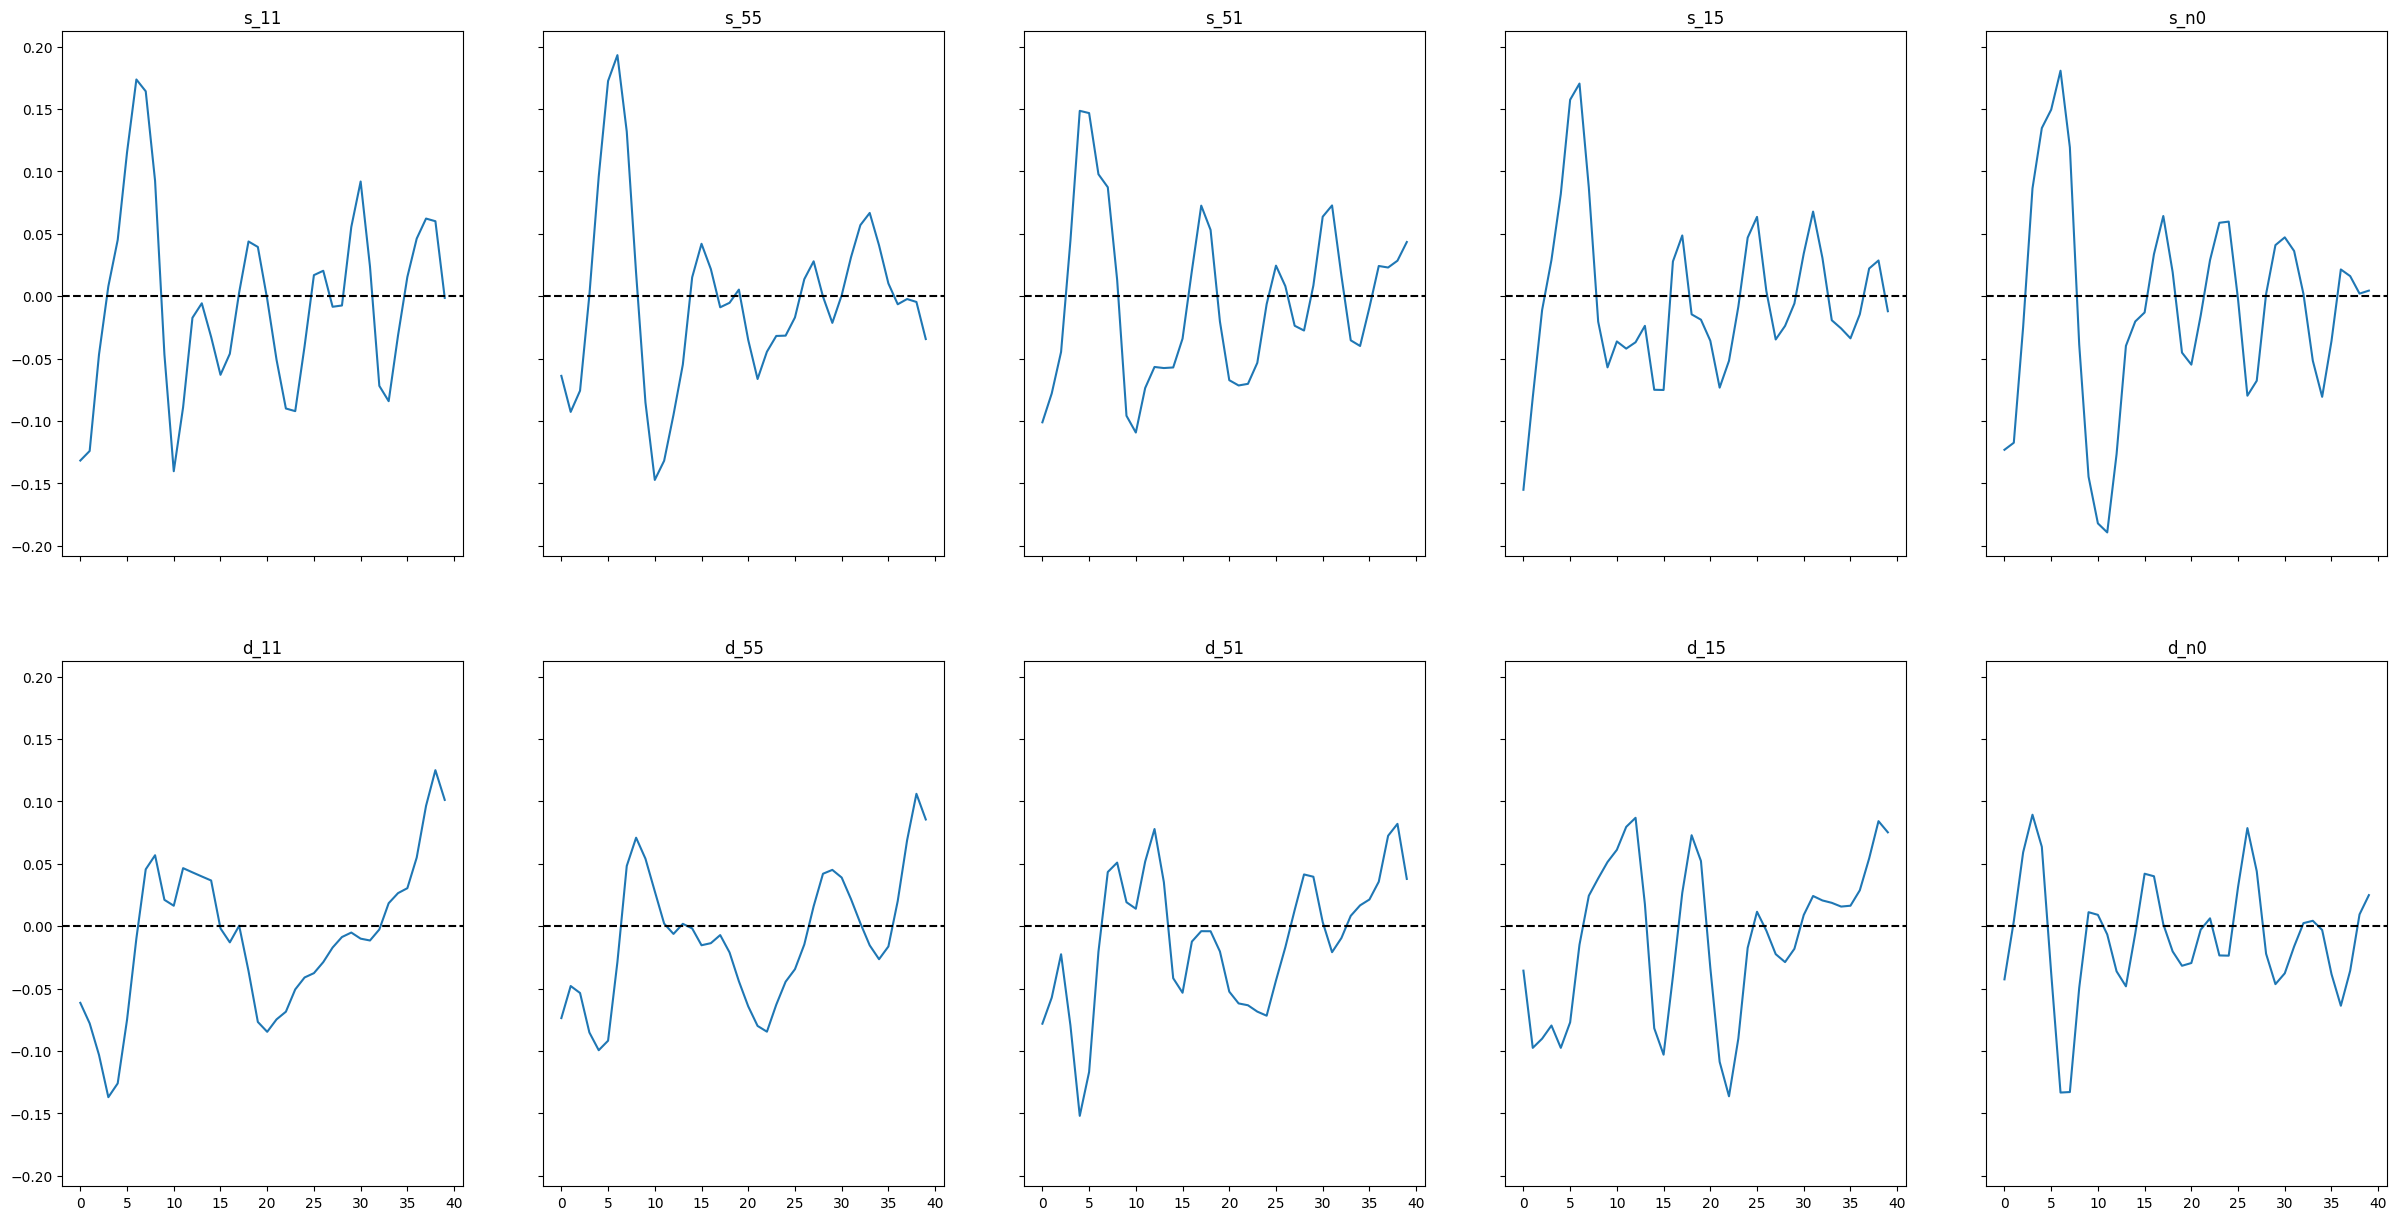

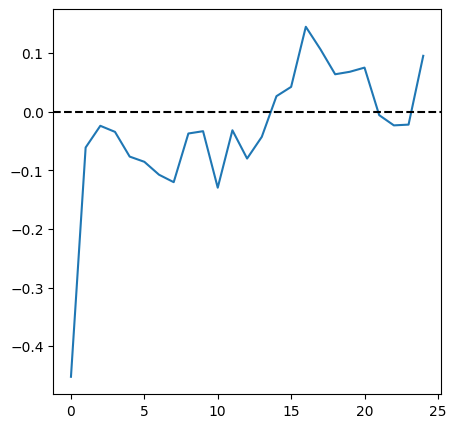

In [187]:
for i in [i_min]:#range(20):
    # 0:const, 1:dm_fix, 2:dm_s11, 3:dm_s55,4:dm_s51,5:dm_s15,6:dm_sn0,7:dm_hist,8:sample_on_off,9:dm_d11,10:dm_d55,11:dm_d51,12:dm_d15,13:dm_dn0,14:delay_on_off
    lam_model = all_models[str(lambdas[i])]
    wparams=list(lam_model.parameters())[0][0,:].detach().numpy()#list(glm_model.parameters())[0][0,:].detach().numpy()#glm_result.params
    variables = list(indices.keys())
    glm_vars = {}
    glm_const = wparams[0:1]#
    glm_vars["glm_const"]=glm_const
    for var in variables:
        st = indices[var][0]
        ed = indices[var][1]
        glm_vars[var] = wparams[st:ed]# glm_result.params
        print(var)
        print(np.sum(wparams[st:ed]))
    # print filters
    variables = [ 's_11', 's_55', 's_51', 's_15', 's_n0', 'd_11', 'd_55', 'd_51', 'd_15', 'd_n0']
    #               'test_orient1', 'test_color1', 
    #              'test_orient2', 'test_color2', 'test_orient3', 'test_color3', 'test_orient4', 'test_color4', 'test_orient5', 'test_color5', 
    #              'test_orient6', 'test_color6', 'test_orient7', 'test_color7', 'test_orient8', 'test_color8']
    cols = 5
    rows = len(variables)//cols
    rows =rows +1 if len(variables)%cols>0 else rows
    f,ax=plt.subplots(rows,cols,figsize=(30,15),sharex=True,sharey=True)
    for iax,var in zip(np.concatenate(ax),variables):
        iax.plot(glm_vars[var])
        iax.axhline(0,color='k',linestyle='--')
        iax.set_title(var)
    f,ax=plt.subplots(figsize=(5,5))
    ax.plot(glm_vars['hist'])
    ax.axhline(0,color='k',linestyle='--')

In [188]:
lam_model = all_models[str(lambdas[i_min])]

In [189]:
for i in [i_min]:#range(15):
    # 0:const, 1:dm_fix, 2:dm_s11, 3:dm_s55,4:dm_s51,5:dm_s15,6:dm_sn0,7:dm_hist,8:sample_on_off,9:dm_d11,10:dm_d55,11:dm_d51,12:dm_d15,13:dm_dn0,14:delay_on_off
    wparams=list(lam_model.parameters())[0][0,:].detach().numpy()#all_allit_w[i][-1]#list(glm_model.parameters())[0][0,:].detach().numpy()#glm_result.params
    variables = list(indices.keys())
    glm_vars = {}
    glm_const = wparams[0:1]#
    glm_vars["glm_const"]=glm_const
    for var in variables:
        st = indices[var][0]
        ed = indices[var][1]
        glm_vars[var] = wparams[st:ed]# glm_result.params

In [190]:
cumsum = np.cumsum(len_tr_train)
cumsum=np.concatenate(([0],cumsum))
start = cumsum[:-1]
end = cumsum[1:]

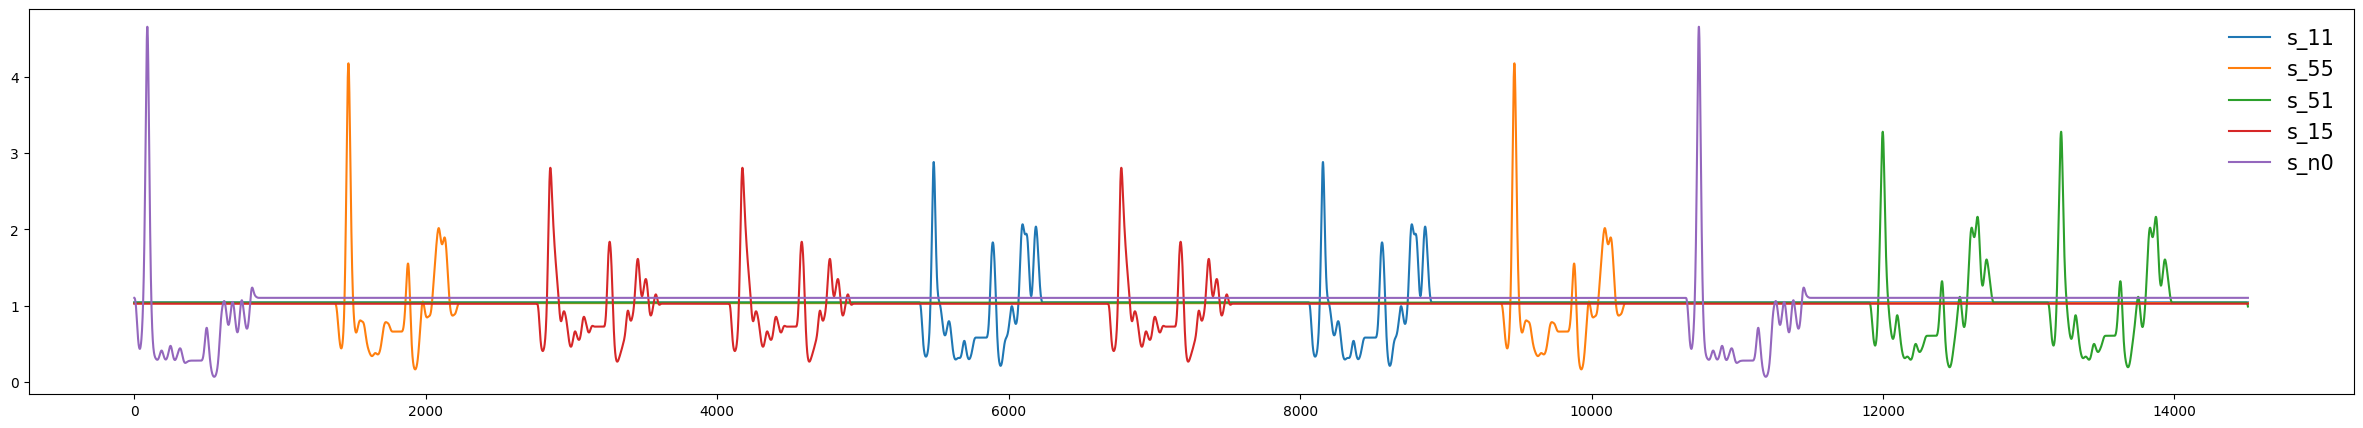

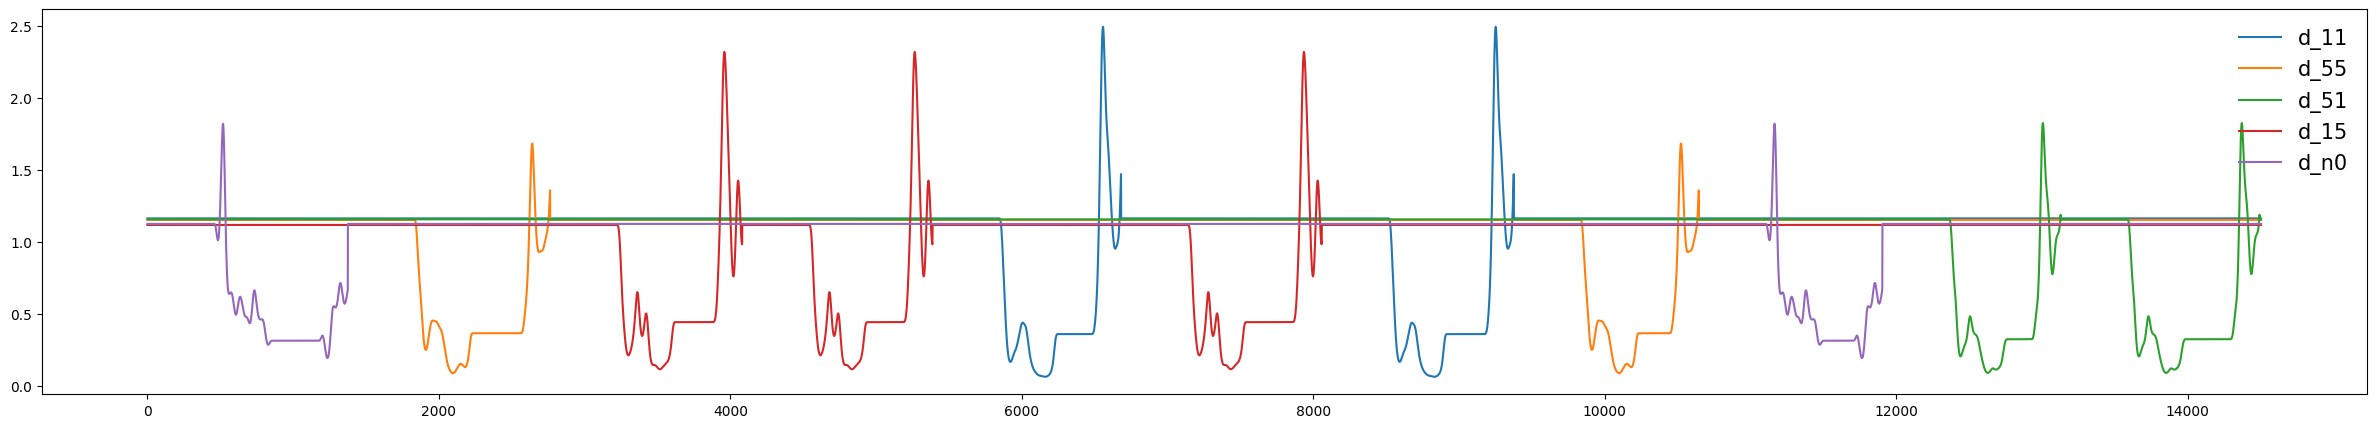

In [191]:
variables = ['s_11', 's_55', 's_51', 's_15','s_n0']#, 
plt.subplots(figsize=(30,5))
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    component= np.exp( dm_train[:,st:ed] @ glm_vars[var])
    
    plt.plot(component[int(start[0]):end[10]+10],label = var)
# plt.vlines(s_on_train[0]-200,0,2,'r')
# plt.vlines(s_on_train[0],0,2,'k')
# plt.vlines(fix_on_train[0],0,2)
# plt.vlines(s_on_train[0]+450,0,2,'k')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')
variables = [ 'd_11', 'd_55', 'd_51', 'd_15', 'd_n0']
plt.subplots(figsize=(30,5))
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    component = np.exp( dm_train[:,st:ed] @ glm_vars[var])
    
    plt.plot(component[int(start[0]):end[10]+10],label = var)
# plt.vlines(s_on_train[0]-200,0,2,'r')
# plt.vlines(s_on_train[0],0,2,'k')
# plt.vlines(fix_on_train[0],0,2)
# plt.vlines(s_on_train[0]+450,0,2,'k')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')



KeyError: 'test_color1'

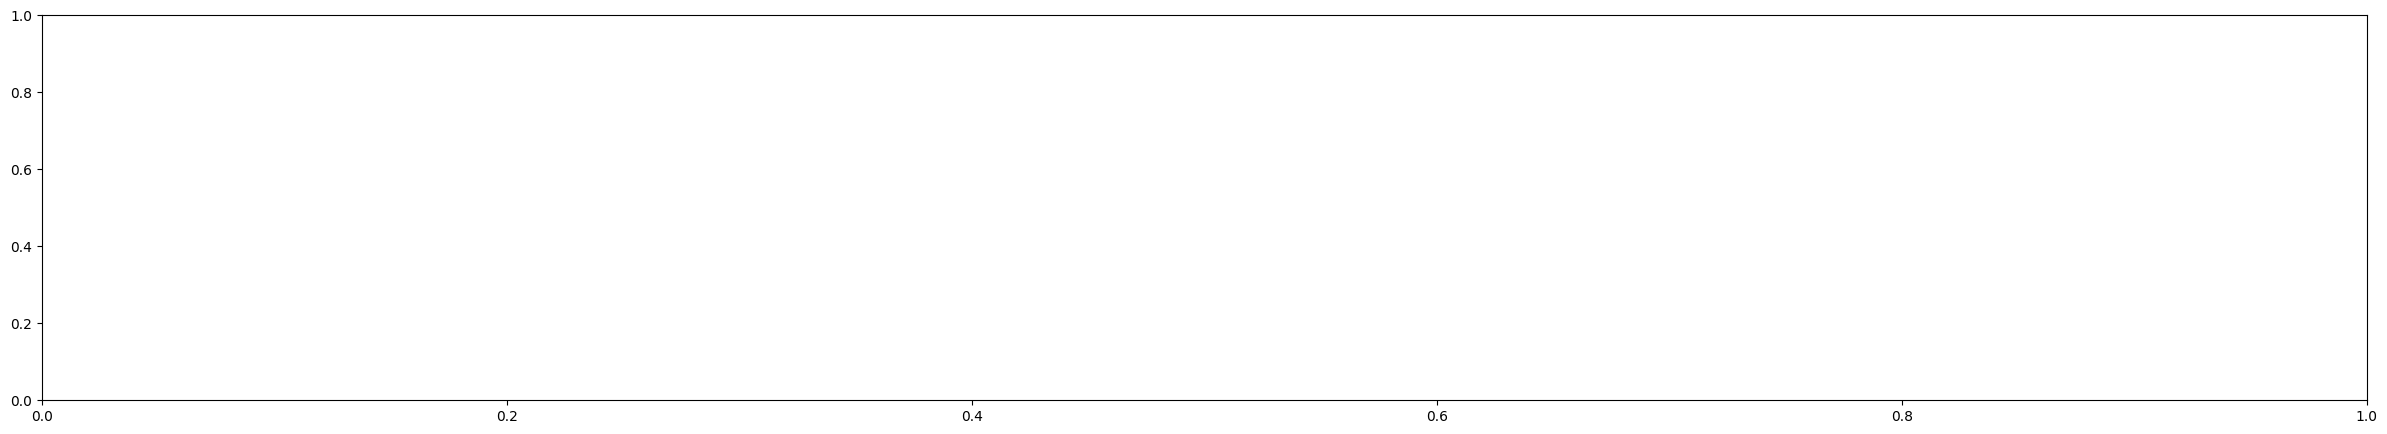

In [192]:
variables = [ 'test_color1', 
              'test_color2',  'test_color3',  'test_color4',  'test_color5', 
              'test_color6',  'test_color7',  'test_color8']
plt.subplots(figsize=(30,5))
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    component = np.exp( dm_train[:,st:ed] @ glm_vars[var])
    
    plt.plot(component[int(start[0]):end[4]+10],label = var)
plt.vlines(s_on_train[0]-200,0,2,'r')
plt.vlines(s_on_train[0],0,2,'k')
plt.vlines(fix_on_train[0],0,2)
plt.vlines(s_on_train[0]+450,0,2,'k')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')
variables = ['test_orient1', 
             'test_orient2', 'test_orient3', 'test_orient4']
plt.subplots(figsize=(30,5))
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    component = np.exp( dm_train[:,st:ed] @ glm_vars[var])
   
    plt.plot(component[int(start[0]):end[4]+10],label = var)
plt.vlines(s_on_train[0]-200,0,2,'r')
plt.vlines(s_on_train[0],0,2,'k')
plt.vlines(fix_on_train[0],0,2)
plt.vlines(s_on_train[0]+450,0,2,'k')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')

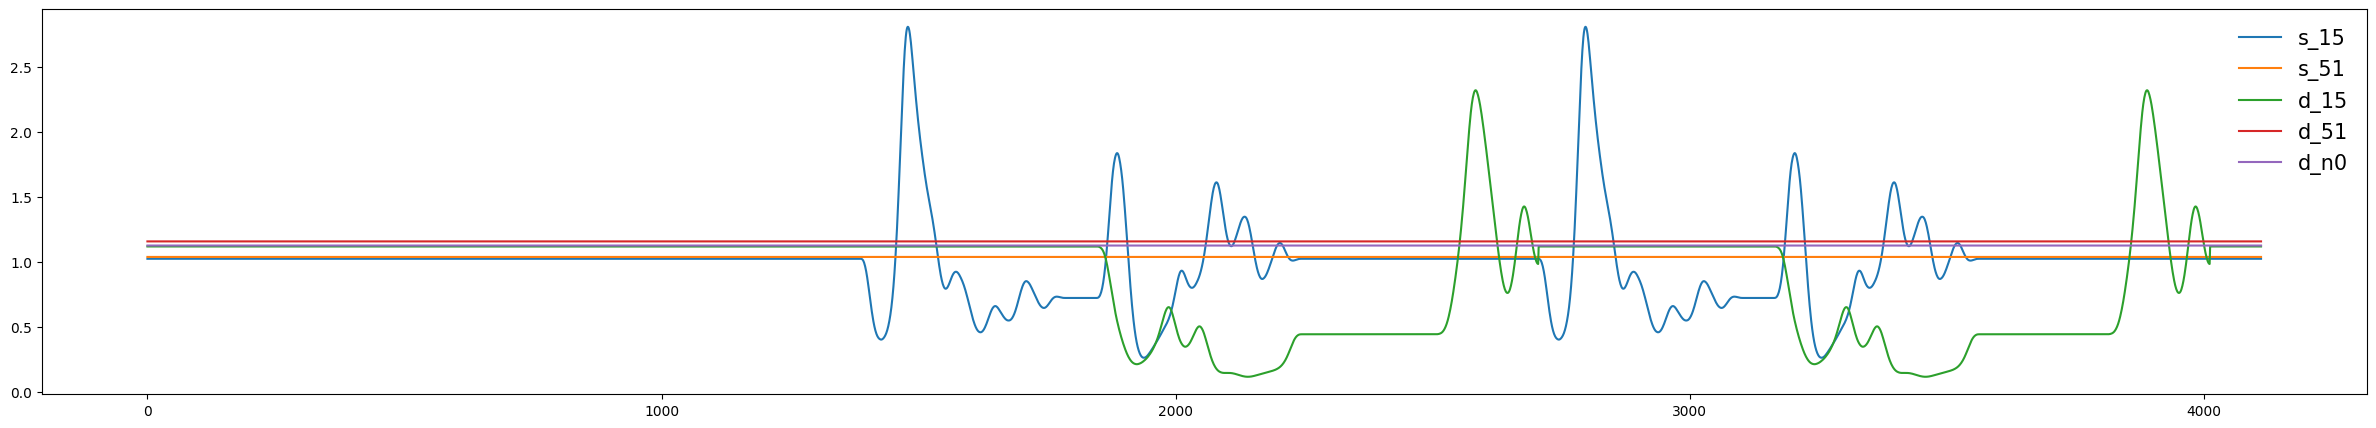

In [193]:
variables = [ 's_15', 's_51','d_15', 'd_51','d_n0']#,'test_orient1', 'test_orient8', 'test_orient5', 'test_color5', 'test_color1','match','bar_release']
plt.subplots(figsize=(30,5))
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    component = np.exp( dm_train[:,st:ed] @ glm_vars[var])
   
    plt.plot(component[int(start[1]):end[3]+100],label = var)

#plt.vlines(neu_data.code_samples[mask][3]-1000,0,2,'k')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')

In [194]:
def get_component(var,dm,glm_vars,indices,start,end):
    st = indices[var][0]
    ed = indices[var][1]
    component= np.exp( dm[:,st:ed] @ glm_vars[var])
    return component[start:end]

In [195]:
idxs_train

array([ 7, 39, 16, 17, 24, 11, 29, 34,  9, 45, 48, 49, 15,  4, 30, 21,  1,
       25, 38, 40,  0, 35, 26, 19,  5, 37, 36, 14, 47, 27,  6, 18,  8, 44,
       10, 20, 41, 46, 31, 28], dtype=int64)

In [196]:
idxs_trials[idxs_train]

array([151, 248,  95, 133, 146, 169,  18,  64, 259, 211,  65, 217,   6,
        24, 132, 270,  97,  12, 158, 105, 185,  57, 116, 242, 138, 142,
       170,   0, 267, 207,  75, 202, 227,  45,  30, 175, 100, 113, 247,
        53], dtype=int64)

In [197]:
all_components={}
# fixation
# var='fix_cue'
# # st = indices[var][0]
# # ed = indices[var][1]
# # component= np.exp( dm_train[:,st:ed] @ glm_vars[var])
# # all_components[var] = component[start[0]:end[0]]
# st = start[0]
# ed = end[0]
# all_components[var] = get_component(var,dm_train,glm_vars,indices,start=st,end=ed)
# # sample
t_befs= 0#400
vars = ['s_11','s_15','s_55','s_51','s_n0']
sampl_ids = [11,15,55,51,0]
for var, s_id in zip(vars,sampl_ids):
    idx=np.where(neu_data.sample_id[mask][idxs_trials[idxs_train]]==s_id)[0]
    st= int(start[idx[0]]+s_on_train[idx[0]]-t_befs)
    ed=end[idx[0]]
    all_components[var] = get_component(var,dm_train,glm_vars,indices,start=st,end=ed)
# delay
vars = ['d_11','d_15','d_55','d_51','d_n0']
t_befd = 400
sampl_ids = [11,15,55,51,0]
for var, s_id in zip(vars,sampl_ids):
    idx=np.where(neu_data.sample_id[mask][idxs_trials[idxs_train]]==s_id)[0]
    st= int(start[idx[0]]+d_on_train[idx[0]]-t_befd)
    ed=end[idx[0]]+100
    all_components[var] = get_component(var,dm_train,glm_vars,indices,start=st,end=ed)

var='hist'
st = indices[var][0]
ed = indices[var][1]
component= np.exp( dm_train[:,st:ed] @ glm_vars[var])
all_components[var] = component[start[5]:end[5]]

Text(0.5, 0.98, 'Component')

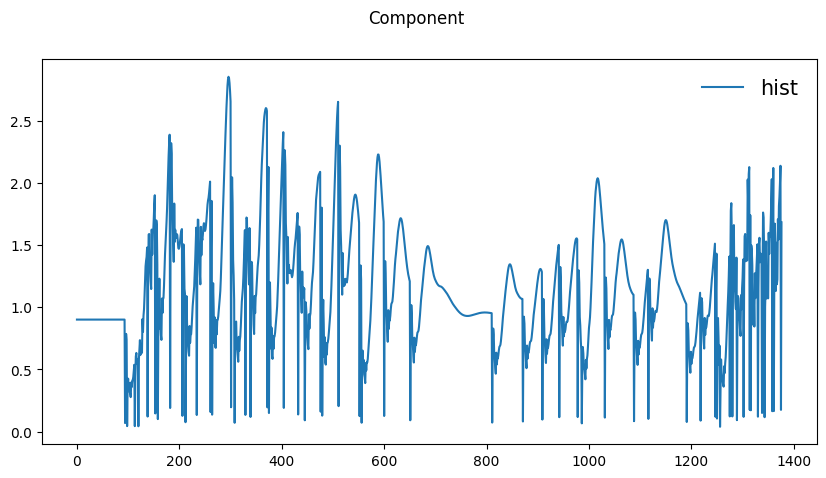

In [198]:
var='hist'
plt.subplots(figsize=(10,5))
t=np.arange(len(all_components[var]))-s_on_train[0]
plt.plot(t,all_components[var],label=var)
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')
plt.suptitle("Component")

In [199]:
all_components.keys()

dict_keys(['s_11', 's_15', 's_55', 's_51', 's_n0', 'd_11', 'd_15', 'd_55', 'd_51', 'd_n0', 'hist'])

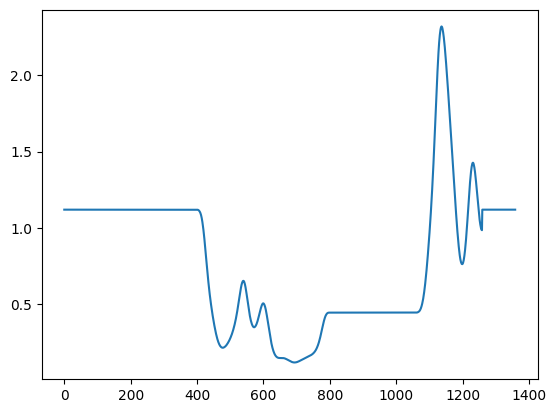

In [200]:
plt.plot(all_components['d_15'])

In [201]:
colors= { "11": "firebrick",
    "15": "teal",
    "51": "tomato",
    "55": "lightseagreen",
    "n0": "grey"}

Text(0.5, 0.98, 'Component')

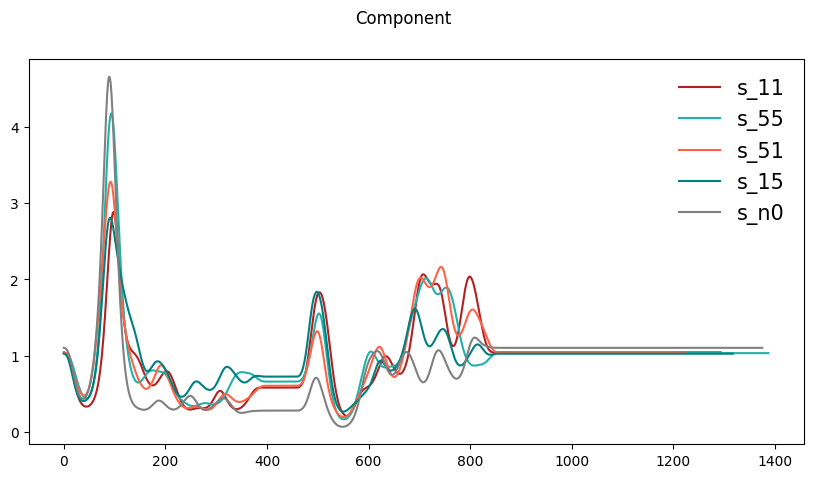

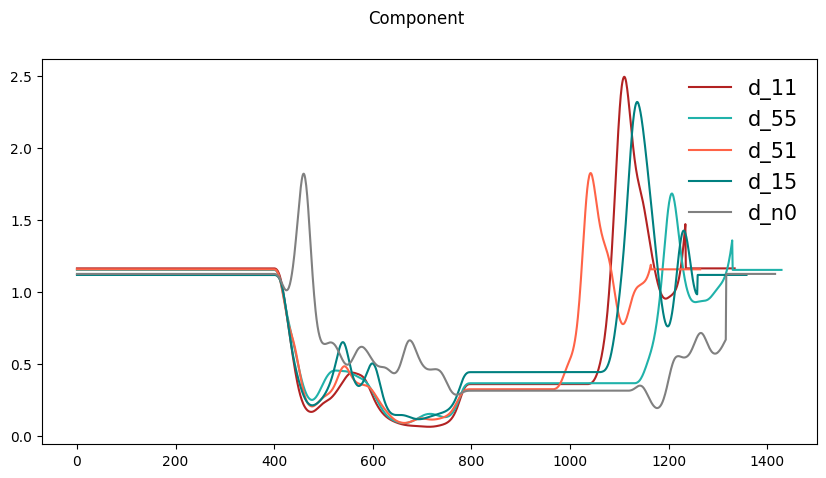

In [202]:
plt.subplots(figsize=(10,5))

for var in ['s_11','s_55','s_51','s_15','s_n0']:
    comp = all_components[var]
    t=np.arange(len(comp[:]))
    
    plt.plot(t,comp[:],label=var,color=colors[var[2:]])
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')
plt.suptitle("Component")
plt.subplots(figsize=(10,5))
for var in ['d_11','d_55','d_51','d_15','d_n0']:
    comp = all_components[var]
    t=np.arange(len(comp[:]))
   
    plt.plot(t,comp[:],label=var,color=colors[var[2:]])
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')
plt.suptitle("Component")

In [ ]:
s_on_train.shape[0]

40

In [ ]:
n0_tr

array([ 0,  8, 13, 16, 20, 24, 30, 32], dtype=int64)

In [203]:
cumsum = np.cumsum(len_tr_train)
cumsum=np.concatenate(([0],cumsum))
start = cumsum[:-1]
end = cumsum[1:]

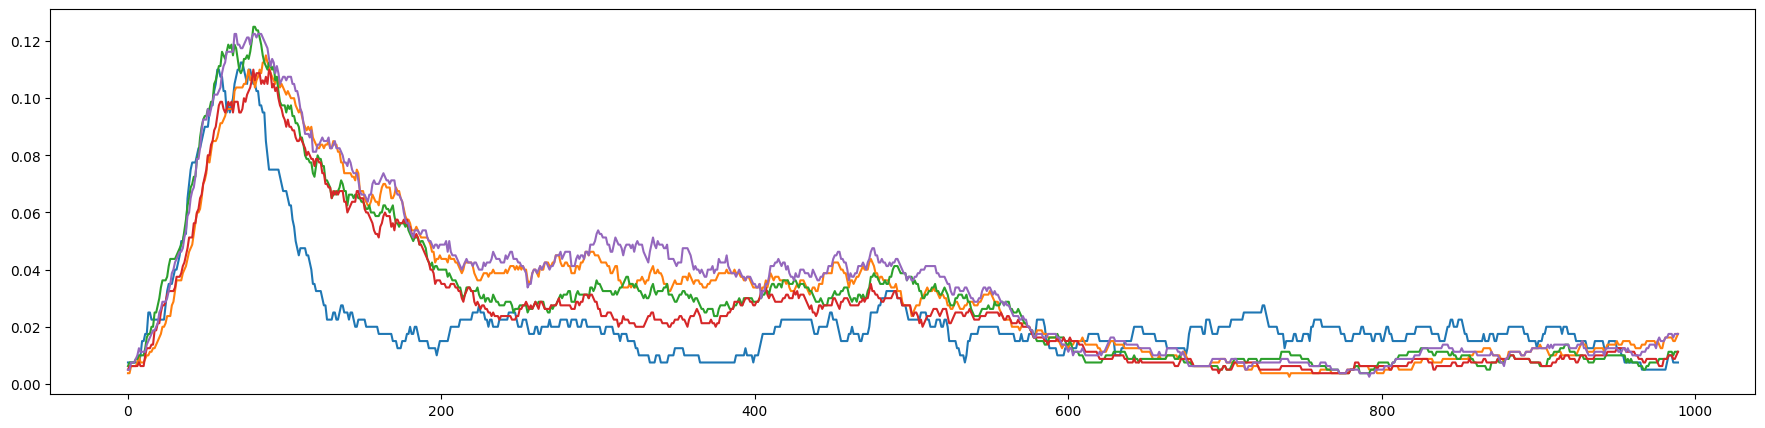

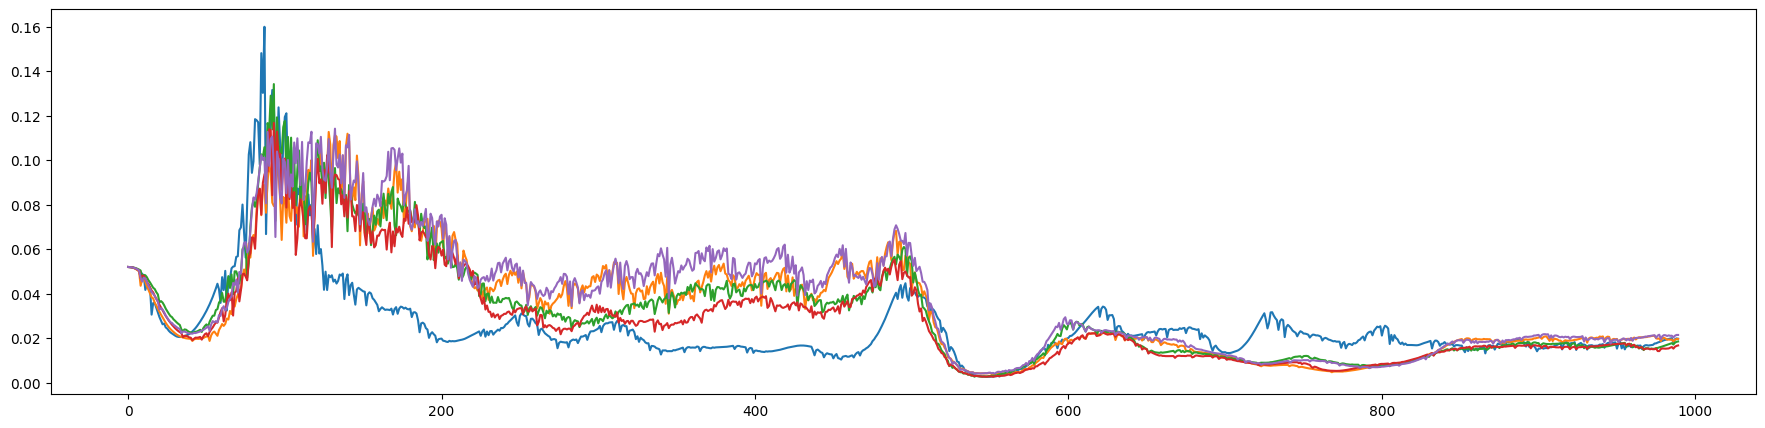

In [204]:

predicted_tr = []
for i_tr in range(s_on_train.shape[0]):
    st=int(s_on_train[i_tr])
    predicted_tr.append(rate_pred_train[start[i_tr]:end[i_tr]][st:int(st+990)])
n0_tr = np.where(neu_data.sample_id[mask][idxs_trials[idxs_train]][:s_on_train.shape[0]]==0)[0]
s11_tr = np.where(neu_data.sample_id[mask][idxs_trials[idxs_train]][:s_on_train.shape[0]]==11)[0]
s15_tr = np.where(neu_data.sample_id[mask][idxs_trials[idxs_train]][:s_on_train.shape[0]]==15)[0]
s51_tr = np.where(neu_data.sample_id[mask][idxs_trials[idxs_train]][:s_on_train.shape[0]]==51)[0]
s55_tr = np.where(neu_data.sample_id[mask][idxs_trials[idxs_train]][:s_on_train.shape[0]]==55)[0]
s11=np.concatenate((s11_tr,s15_tr)).tolist()
s55=np.concatenate((s51_tr,s55_tr)).tolist()
s51=np.concatenate((s11_tr,s51_tr)).tolist()
s15=np.concatenate((s55_tr,s15_tr)).tolist()

sp_tr = []
for i_tr in range(s_on_train.shape[0]):
    st=int(s_on_train[i_tr])
    dat = sp_train[start[i_tr]:end[i_tr]]
    sp_tr.append(firing_rate.moving_average(data=dat, win=50, step = 1)[st:int(st+990)])
plt.subplots(figsize=(22,5))
plt.plot(np.array(sp_tr)[n0_tr].mean(axis=0))
plt.plot(np.array(sp_tr)[s11].mean(axis=0))
plt.plot(np.array(sp_tr)[s55].mean(axis=0))
plt.plot(np.array(sp_tr)[s51].mean(axis=0))
plt.plot(np.array(sp_tr)[s15].mean(axis=0))
plt.subplots(figsize=(22,5))
plt.plot(np.array(predicted_tr)[n0_tr].mean(axis=0))
plt.plot(np.array(predicted_tr)[s11].mean(axis=0))
plt.plot(np.array(predicted_tr)[s55].mean(axis=0))
plt.plot(np.array(predicted_tr)[s51].mean(axis=0))
plt.plot(np.array(predicted_tr)[s15].mean(axis=0))

In [205]:
# rate_pred_test = np.exp(glm_const + dm_test@ wparams[1:])
rate_pred_test = lam_model(X_ten_test.cpu())
rate_pred_test = rate_pred_test.detach().numpy()

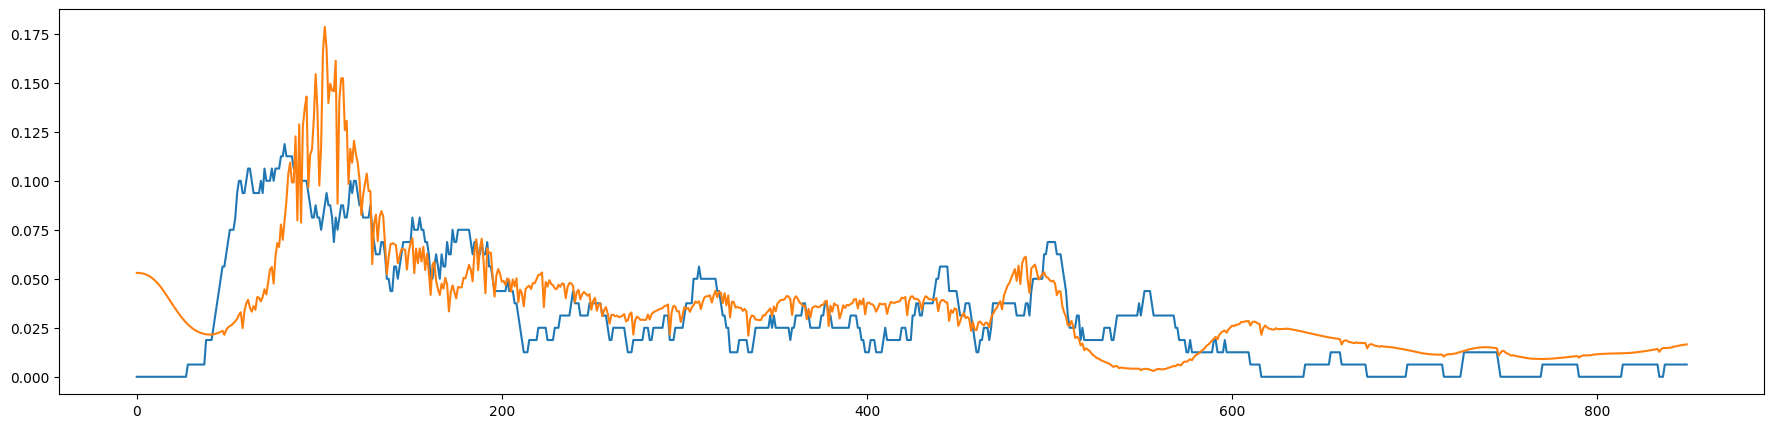

In [206]:
cumsum = np.cumsum(len_tr_test)
cumsum=np.concatenate(([0],cumsum))
start = cumsum[:-1]
end = cumsum[1:]

predicted_tr = []
for i_tr in range(s_on_test.shape[0]):
    st=int(s_on_test[i_tr])
    predicted_tr.append(rate_pred_test[start[i_tr]:end[i_tr]][st:int(st+850)])
no_neu = np.where(neu_data.sample_id[mask][:s_on_test.shape[0]]!=0)[0]

sp_tr = []
for i_tr in range(s_on_test.shape[0]):
    st=int(s_on_test[i_tr])
    dat = sp_test[start[i_tr]:end[i_tr]]
    sp_tr.append(firing_rate.moving_average(data=dat, win=20, step = 1)[st:int(st+850)])
plt.subplots(figsize=(22,5))
plt.plot(np.array(sp_tr)[no_neu].mean(axis=0))
plt.plot(np.array(predicted_tr)[no_neu].mean(axis=0))

In [207]:
s_on_test.shape[0]

10

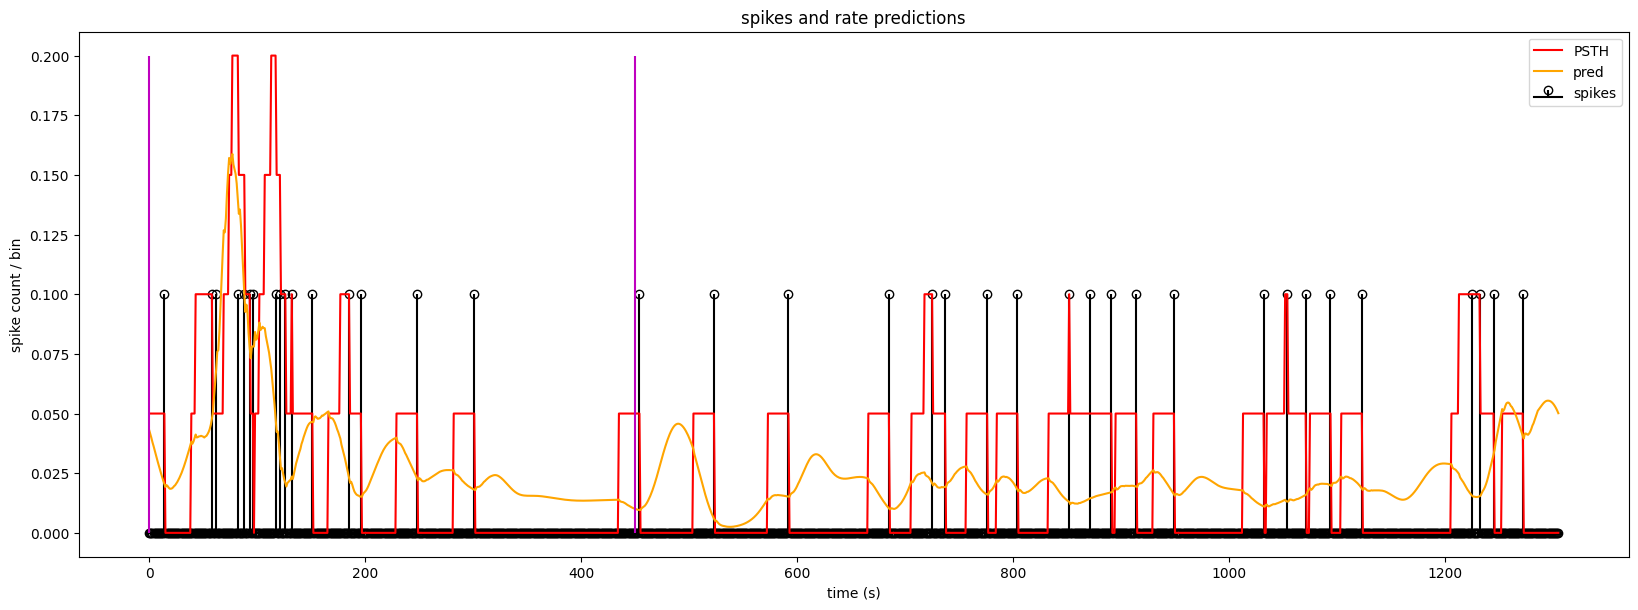

In [208]:
# Compute predicted spike rate on training data
#rate_pred = np.exp(glm_const + dm_train@ glm_result.params[1:])
cumsum = np.cumsum(len_tr_train)
cumsum=np.concatenate(([0],cumsum))
start = cumsum[:-1]
end = cumsum[1:]
it=20
t_start,t_end=start[it],end[it]
# Make plot
fig = plt.figure(figsize=[20,15])
iiplot = np.arange(0,t_end-t_start)
ttplot = iiplot*1
plt.subplot(212)
markerline,_,_ = plt.stem(ttplot, (sp_train[t_start:t_end][iiplot]/10), linefmt='k-', basefmt='k-', label='spikes')
plt.setp(markerline, 'markerfacecolor', 'none')
plt.setp(markerline, 'markeredgecolor', 'k')
dat= sp_train
plt.plot(ttplot,firing_rate.moving_average(data=dat[t_start:t_end], win=20, step = 1), c='red', label='PSTH')
plt.plot(ttplot,firing_rate.moving_average(data=rate_pred_train.reshape(-1), win=20, step = 1)[t_start:t_end], c='orange', label='pred')

_=plt.vlines(s_on_train[it],0,0.2,'m')
_=plt.vlines(s_on_train[it]+450,0,0.2,'m')
#_=plt.vlines(fix_on_train[it],0,0.2)

plt.legend()
plt.xlabel('time (s)')
plt.title('spikes and rate predictions')
plt.ylabel('spike count / bin')
plt.show()

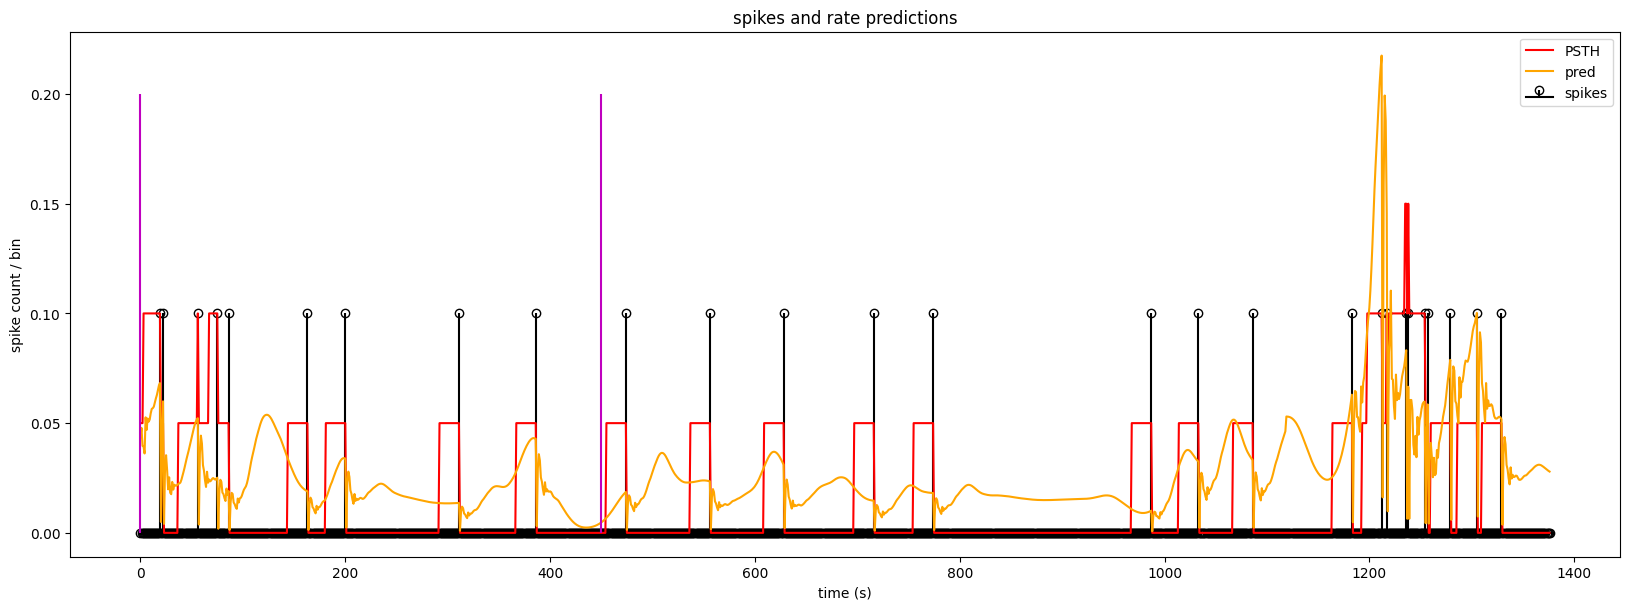

In [209]:
# Compute predicted spike rate on testing data
#rate_pred = np.exp(glm_const + dm_test@ glm_result.params[1:])
it=5
t_start,t_end=start[it],end[it]
# Make plot
fig = plt.figure(figsize=[20,15])
iiplot = np.arange(0,t_end-t_start)
ttplot = iiplot*1
plt.subplot(212)
markerline,_,_ = plt.stem(ttplot, (sp_test[t_start:t_end][iiplot]/10), linefmt='k-', basefmt='k-', label='spikes')
plt.setp(markerline, 'markerfacecolor', 'none')
plt.setp(markerline, 'markeredgecolor', 'k')
dat= sp_test[t_start:t_end]
plt.plot(ttplot,firing_rate.moving_average(data=dat, win=20, step = 1), c='red', label='PSTH')
plt.plot(ttplot,rate_pred_test[t_start:t_end], c='orange', label='pred')

_=plt.vlines(s_on_test[it],0,0.2,'m')
_=plt.vlines(s_on_test[it]+450,0,0.2,'m')
#_=plt.vlines(fix_on_test[it],0,0.2)

plt.legend()
plt.xlabel('time (s)')
plt.title('spikes and rate predictions')
plt.ylabel('spike count / bin')
plt.show()

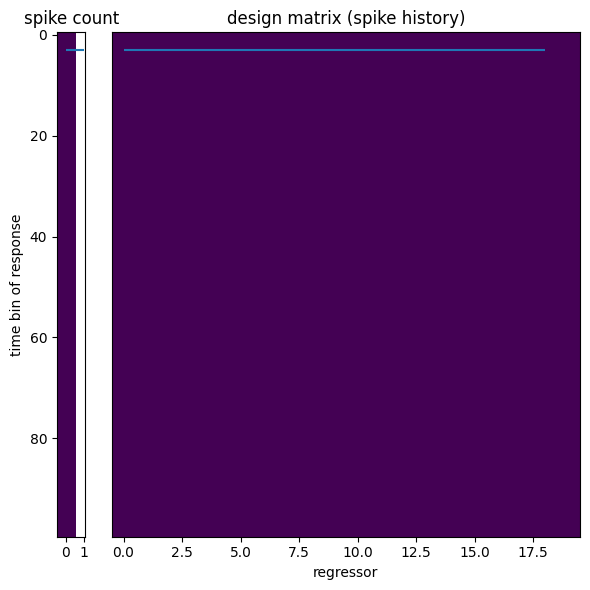

In [ ]:
ntfilt = 20     # Try varying this, to see how performance changes!

# Build the design matrix
padded_stim = np.hstack((np.zeros((ntfilt)), sp_train)) # pad early bins of stimulus with zero
design_mat_hist = np.zeros((len(sp_train),ntfilt))
for j in np.arange(len(sp_train)):
    design_mat_hist[j] = np.flip(padded_stim[j:j+ntfilt]) # grab last 'nkt' bins of stmiulus and insert into this row

t_train,_=dm_train.shape

#dm_train_offset = np.hstack((np.ones((t_train,1)), dm_train))  
fig = plt.figure(figsize=[6,6])
plt.subplot(1,10,(2,10))
plt.imshow(design_mat_hist[165:265], aspect='auto', interpolation='nearest')
plt.yticks(ticks=[], labels=[])
plt.hlines(3,0,18)
plt.xlabel('regressor')

plt.title('design matrix (spike history)')
plt.subplot(1,10,1)
plt.imshow(sp_train[165:265,np.newaxis], aspect='auto', interpolation='nearest')
plt.ylabel('time bin of response')
plt.title('spike count')
plt.tight_layout()
plt.hlines(3,0,1)
plt.show()

{'hist': [0, 25],
 's_11': [25, 65],
 's_15': [65, 105],
 's_51': [105, 145],
 's_55': [145, 185],
 's_n0': [185, 225],
 'd_11': [225, 265],
 'd_15': [265, 305],
 'd_51': [305, 345],
 'd_55': [345, 385],
 'd_n0': [385, 425]}

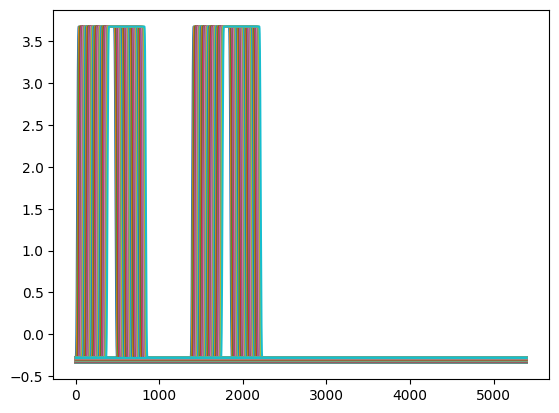

In [ ]:
_=plt.plot((dm_train[int(start[0]):end[3]+10,105: 265]))
indices

In [ ]:
np.max(dm_test)

8.882003711694473

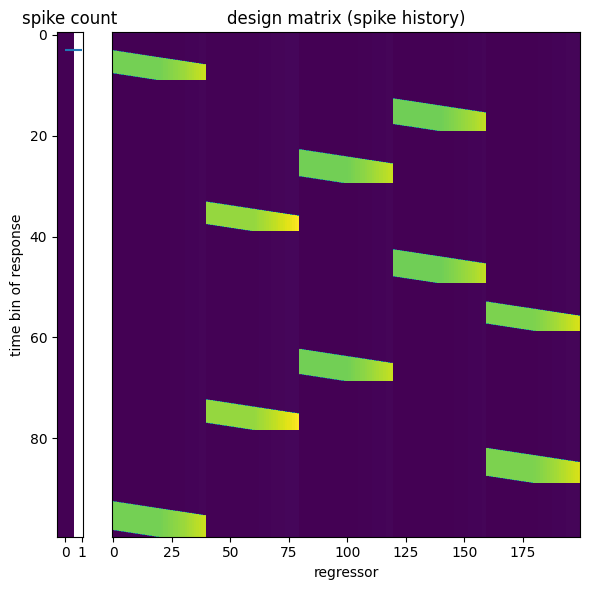

In [ ]:
fig = plt.figure(figsize=[6,6])
plt.subplot(1,10,(2,10))
plt.imshow(dm_test[int(start[0]):end[-1]+5,225: 425], aspect='auto', interpolation='nearest')
plt.yticks(ticks=[], labels=[])
plt.hlines(3,0,18)
plt.xlabel('regressor')

plt.title('design matrix (spike history)')
plt.subplot(1,10,1)
plt.imshow(sp_train[165:265,np.newaxis], aspect='auto', interpolation='nearest')
plt.ylabel('time bin of response')
plt.title('spike count')
plt.tight_layout()
plt.hlines(3,0,1)
plt.show()